# Two Stage VAE

An article from NeurIPS 2018 explained a way of altering Variational Autoencoders that leads to better image results. This is measured against the tensorflow implementation of FID, which is used to determine image diversity (i.e. how many different images the generator can produce) and image quality (i.e. how similar the generated images are to real images, as measured by a particular network). 

In brief, the alteration is to change how we measure the reconstruction. A typical measure of the reconstruction is the log probability of the outcome. Given an observation $x$, 


This shortcoming is that the network is more apt to learn the *shape* of the manifold rather than the *distribution of data* on the manifold. Because of this, a standard VAE finds itself producing blurry pictures due to this mismatch in distribution. To remedy this, they propose a simple fix: add a second VAE to learn the distribution of data, once the shape of the manifold has been reasonably learned.

This notebook is an implementation of this idea in pytorch. The network used herein is much smaller, but the result should still be observable with a small network.

In [1]:
import torch
import torch.nn as nn

import torchvision.datasets as datasets
from torchvision.transforms import Compose, Normalize, ToTensor, Pad
from torchvision.transforms.functional import to_pil_image

from math import sqrt, exp, log, pi

from matplotlib.pylab import imshow

In [2]:
#Choose training device (cpu vs gpu/cuda) based on availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class image_loader:
    def __init__(self, dataset, colorize=False):
        '''
        Utility class used to dispose of image labels.
        :param dataset: ([Tensor, label]) List of tensors
            and labels.
        :param colorize: (Bool, optional) Adds random
            color if true. Intended for single channel
            images.
        '''
        self.dataset = dataset
        self.colorize = colorize
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        '''
        Returns the image corresponding to index idx. If
        the colorize attribute is True, the image is then
        randomly colorized. If color is not none, then
        that color is used.
        '''
        
        x = self.dataset[idx][0]
        if self.colorize:
            x = x*torch.rand((3, 1, 1), device=x.device)
        
        return x

    def color(self, idx, color):
        if type(color) == str:
            color = self.hex_to_tensor(color)
        x = self.dataset[idx][0]
        color = color.reshape((3, 1, 1)).to(device=x.device)
        return x*color

    @staticmethod
    def hex_to_tensor(hex_color):
        assert hex_color[0] == '#'
        rgb = [int(hex_color[1+2*i:3+2*i], 16)/255. for i in range(3)]
        return torch.tensor(rgb)

In [4]:
#Choose data set and batch size
transforms = Compose([Pad(2), ToTensor()])
dataset = datasets.FashionMNIST(root='./data/', train=True, download=False, transform=transforms)
image_set = image_loader(dataset, colorize=True)
batch_size = 125
training_loader = torch.utils.data.DataLoader(dataset=image_set, batch_size=batch_size, shuffle=True)

#Set image size. This is done for convenience when changing data.
image_shape = (3, 32, 32)
image_size = image_shape[0]*image_shape[1]*image_shape[2]

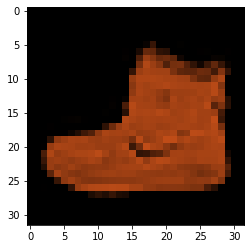

In [5]:
imshow(to_pil_image(image_set[0]))

In [6]:
class VariationalEncoder(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(VariationalEncoder, self).__init__()
        self.mean = nn.Linear(in_features, out_features, bias=bias)
        self.log_var = nn.Linear(in_features, out_features, bias=bias)
        
    def forward(self, input):
        mean = self.mean(input)
        scale = (self.log_var(input)/2).exp()
        return mean, scale
    
    def __repr__(self):
        return 'VariationalEncoder(in_features={0}, out_features={1}, bias={2})'.format(
            self.mean.in_features,
            self.mean.out_features,
            self.mean.bias is not None
        )
    
class ReshapeLayer(nn.Module):
    '''
    Reshapes the input to be the output using view. Shapes are checked
    on forward pass to verify that they are compatible.

    :param view_shape: The shape to cast the input to. Given a batch
        input of shape (n, _) will be cast to (n, view_shape).
    '''
    def __init__(self, out_shape):
        super(ReshapeLayer, self).__init__()
        self.out_shape = out_shape

    def forward(self, x):
        '''
        Reshapes x to initialized shape.
        :param x: (torch.Tensor)
        :return: (torch.Tensor)
        '''
        output_shape = (x.shape[0],) + self.out_shape
        assert self.dimension(x.shape) == self.dimension(output_shape), \
            '{0} and {1} are not compatabile'.format(x.shape, output_shape)
        return x.reshape(output_shape)

    @staticmethod
    def dimension(shape):
        #Helper function for checking dimensions
        out = 1
        for s in shape:
            out *= s
        return out
    
    def __repr__(self):
        return 'ReshapeLayer(out_shape={0})'.format(self.out_shape)

In [7]:
class learned_log_prob(nn.Module):
    def __init__(self, log_gamma=0.):
        super(learned_log_prob, self).__init__()
        self.log_gamma = nn.Parameter(torch.zeros(1))
        
    def forward(self, input, target):
        log_prob = torch.sum(torch.pow((input.flatten(1)-target.flatten(1))/self.log_gamma.exp(), 2)/2 \
                         + self.log_gamma \
                         + log(2*pi)/2, 1)
        return log_prob
    
    @property
    def gamma(self):
        return self.log_gamma.exp()
    
    def __repr__(self):
        return 'learned_log_prob(gamma={0:.3f})'.format(float(self.gamma))

In [8]:
def KL(mean, scale):
        '''
        Computes the KL divergence of a normal distribution with the parameters above
        from N(0, 1) on a batch and then returns the mean.

        :param means: (torch.Tensor)
        :param scale: (torch.Tensor)
        :return: The KL divergence
        '''
        variance = scale.pow(2)
        loss = torch.sum(variance+mean.pow(2)-torch.log(variance)-1, 1)/2.
        #Return batch average
        return loss.mean()

def MSE(input, target):
        '''
        Computes mean squared error of a sample.
        
        :param x: (torch.Tensor)
        :param y: (torch.Tensor)
        :return: (torch.Tensor)
        '''
        loss = torch.sum(torch.pow(input.flatten(1)-target.flatten(1), 2)/2, 1)
        return loss.mean()

In [9]:
def print_progress(intro_dict, progress_dict):
    '''
    Prints information from two dictionaries. The first dictionary is printed verbatim,
    while the second dictionary is rounded to 4 decimals. The values of the second
    dictionary must be floats.
    
    :param intro_dict: (dict) Information about the current time. The {key: value}
        pair can have any value that can be used in a str formatorch.
    :param progress_dict: (dict) Information about current progress. The {key: value}
        pair must have a float for the value.
    '''
    intro_text = '{}: {:4}'
    intros = [intro_text.format(key, value) for key, value in intro_dict.items()]
    update_text = '{}: {:.4f}'
    updates = [update_text.format(key, value) for key, value in progress_dict.items()]
    print(*intros, *updates, sep=' - ')

## Train first variational autoencoder

In [10]:
def train_VAE(
    encoder,
    decoder,
    learned_log_prob,
    optimizer,
    optim_schedule,
    training_loader,
    epochs,
    device='cpu',
):
    print('Training network.')
    #Train big network
    batches = len(training_loader)
    for epoch in range(epochs):
        running_MSE = 0.
        running_z = 0.
        running_log_prob = 0.
        for batch_nb, x in enumerate(training_loader):
            x = x.to(device)

            #Encode to z
            means, scales = encoder(x)
            eps = torch.randn_like(scales, device=device)
            z = eps*scales+means

            #Decode to image
            x_hat = decoder(z)

            #Compute loss
            z_loss = KL(means, scales)

            log_loss = torch.mean(learned_log_prob(x, x_hat))
            loss = z_loss + log_loss

            #Track statistics. Use float to detach the graph from the tensors
            running_log_prob = 0.9*running_log_prob + 0.1*float(log_loss)
            running_z = 0.9*running_z + 0.1*float(z_loss)
            running_MSE = 0.9*running_MSE + 0.1*float(MSE(x, x_hat))

            #Update network
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if batch_nb % 50 == 49:
                #Print progress
                info_dict = {
                    'Epoch': epoch,
                    'Batch': batch_nb+1
                }
                progress_dict = {
                    'log prob': running_log_prob,
                    'Encoding loss': running_z,
                    'MSE': running_MSE,
                    'gamma': float(learned_log_prob.gamma)
                }
                print_progress(info_dict, progress_dict)

        #Update learning rate
        optim_schedule.step()

    print('Training complete.')

In [29]:
z_size = 32
nc = image_shape[0]
filters = 32*nc

#Build networks
big_encoder = nn.Sequential(
    #current shape: 3 x 32 x 32
    nn.Conv2d(nc, filters, 4, 2, 1),
    nn.ReLU(),
    #current shape: filters x 16 x 16
    nn.Conv2d(filters, filters, 4, 2, 1),
    nn.ReLU(),
    #current shape: filters x 8 x 8
    nn.Conv2d(filters, filters, 4, 2, 1),
    nn.ReLU(),
    #current shape: filters x 4 x 4
    nn.Flatten(),
    #current shape: 16*filters
    nn.Linear(16*filters, 4*z_size, bias=True),
    nn.ReLU(),
    VariationalEncoder(4*z_size, z_size, bias=False)
)

big_decoder = nn.Sequential(
    nn.Linear(z_size, 4*z_size, bias=True),
    nn.ReLU(),
    nn.Linear(4*z_size, 16*filters, bias=True),
    nn.ReLU(),
    ReshapeLayer((filters, 4, 4)),
    nn.ReLU(),
    nn.ConvTranspose2d(filters, filters, 4, 2, 1),
    nn.ReLU(),
    nn.ConvTranspose2d(filters, filters, 4, 2, 1),
    nn.ReLU(),
    nn.ConvTranspose2d(filters, nc, 4, 2, 1),
    nn.Sigmoid(),
)

big_log_prob = learned_log_prob()

#Load previously trained models, if they exist. Passes if they do not.
try:
    big_encoder.load_state_dict(torch.load('./samples/2layer/big_encoder.pkl'))
    big_decoder.load_state_dict(torch.load('./samples/2layer/big_decoder.pkl'))
    big_log_prob.load_state_dict(torch.load('./samples/2layer/big_log_prob.pkl'))
except FileNotFoundError:
    pass
#Move networks to selected device
big_encoder.to(device)
big_decoder.to(device)
big_log_prob.to(device)

print(big_encoder)
print(big_decoder)
print(big_log_prob)

Sequential(
  (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(96, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(96, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Flatten()
  (7): Linear(in_features=1536, out_features=128, bias=True)
  (8): ReLU()
  (9): VariationalEncoder(in_features=128, out_features=32, bias=False)
)
Sequential(
  (0): Linear(in_features=32, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=1536, bias=True)
  (3): ReLU()
  (4): ReshapeLayer(out_shape=(96, 4, 4))
  (5): ReLU()
  (6): ConvTranspose2d(96, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): ConvTranspose2d(96, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (9): ReLU()
  (10): ConvTranspose2d(96, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (11): Sigmoid()
)
learned_log_prob(gamma=1.000)


In [30]:
#Collect parameters
big_params = list(big_encoder.parameters())+list(big_decoder.parameters())+list(big_log_prob.parameters())

#Set up optimizer
lr = 1e-4
big_optimizer = torch.optim.Adam(big_params, lr=lr)

In [31]:
#Set number of epochs
big_epochs = 50

#Set up learning rate decay schedule. Set to decay by half every 40%
epochs_per_decay = max(big_epochs*2//5, 1)
big_schedule = torch.optim.lr_scheduler.StepLR(big_optimizer, epochs_per_decay, 0.5)

train_VAE(
    big_encoder,
    big_decoder,
    big_log_prob,
    big_optimizer,
    big_schedule,
    training_loader,
    big_epochs,
    device
)

torch.save(big_encoder.state_dict(), './samples/2layer/big_encoder.pkl')
torch.save(big_decoder.state_dict(), './samples/2layer/big_decoder.pkl')
torch.save(big_log_prob.state_dict(), './samples/2layer/big_log_prob.pkl')

Training network.
Epoch:    0 - Batch:   50 - log prob: 2942.2979 - Encoding loss: 8.1130 - MSE: 145.2013 - gamma: 0.9949
Epoch:    0 - Batch:  100 - log prob: 2872.4262 - Encoding loss: 2.2085 - MSE: 76.7127 - gamma: 0.9897
Epoch:    0 - Batch:  150 - log prob: 2831.1643 - Encoding loss: 2.4851 - MSE: 51.4374 - gamma: 0.9845
Epoch:    0 - Batch:  200 - log prob: 2810.1523 - Encoding loss: 1.9568 - MSE: 46.0864 - gamma: 0.9794
Epoch:    0 - Batch:  250 - log prob: 2792.0700 - Encoding loss: 1.9264 - MSE: 43.5056 - gamma: 0.9744
Epoch:    0 - Batch:  300 - log prob: 2774.8160 - Encoding loss: 1.9674 - MSE: 41.6611 - gamma: 0.9694
Epoch:    0 - Batch:  350 - log prob: 2758.0451 - Encoding loss: 2.1502 - MSE: 40.2457 - gamma: 0.9644
Epoch:    0 - Batch:  400 - log prob: 2740.8635 - Encoding loss: 2.6116 - MSE: 38.4383 - gamma: 0.9595
Epoch:    0 - Batch:  450 - log prob: 2723.2536 - Encoding loss: 2.9905 - MSE: 36.2459 - gamma: 0.9547
Epoch:    1 - Batch:   50 - log prob: 2684.6266 - Enco

Epoch:    8 - Batch:  400 - log prob: 1557.0277 - Encoding loss: 8.9050 - MSE: 17.4830 - gamma: 0.6528
Epoch:    8 - Batch:  450 - log prob: 1541.4465 - Encoding loss: 8.7616 - MSE: 17.2061 - gamma: 0.6496
Epoch:    9 - Batch:   50 - log prob: 1508.9087 - Encoding loss: 8.7831 - MSE: 16.8063 - gamma: 0.6444
Epoch:    9 - Batch:  100 - log prob: 1500.6530 - Encoding loss: 8.8357 - MSE: 16.4094 - gamma: 0.6412
Epoch:    9 - Batch:  150 - log prob: 1486.3589 - Encoding loss: 8.9287 - MSE: 16.6580 - gamma: 0.6380
Epoch:    9 - Batch:  200 - log prob: 1471.4947 - Encoding loss: 8.9740 - MSE: 16.6839 - gamma: 0.6348
Epoch:    9 - Batch:  250 - log prob: 1456.6654 - Encoding loss: 9.0207 - MSE: 16.7206 - gamma: 0.6317
Epoch:    9 - Batch:  300 - log prob: 1440.1135 - Encoding loss: 9.1335 - MSE: 16.0738 - gamma: 0.6285
Epoch:    9 - Batch:  350 - log prob: 1425.8093 - Encoding loss: 9.1769 - MSE: 16.3185 - gamma: 0.6254
Epoch:    9 - Batch:  400 - log prob: 1411.1913 - Encoding loss: 9.0587 -

Epoch:   17 - Batch:  300 - log prob: 267.4913 - Encoding loss: 14.7371 - MSE: 8.5830 - gamma: 0.4282
Epoch:   17 - Batch:  350 - log prob: 253.8719 - Encoding loss: 14.6745 - MSE: 8.8076 - gamma: 0.4261
Epoch:   17 - Batch:  400 - log prob: 239.2945 - Encoding loss: 14.8874 - MSE: 8.8528 - gamma: 0.4240
Epoch:   17 - Batch:  450 - log prob: 223.8867 - Encoding loss: 14.8922 - MSE: 8.7473 - gamma: 0.4219
Epoch:   18 - Batch:   50 - log prob: 198.0304 - Encoding loss: 14.8872 - MSE: 8.5192 - gamma: 0.4185
Epoch:   18 - Batch:  100 - log prob: 185.2819 - Encoding loss: 14.7617 - MSE: 8.7326 - gamma: 0.4165
Epoch:   18 - Batch:  150 - log prob: 170.1030 - Encoding loss: 15.0402 - MSE: 8.6677 - gamma: 0.4144
Epoch:   18 - Batch:  200 - log prob: 156.2457 - Encoding loss: 15.2227 - MSE: 8.8284 - gamma: 0.4123
Epoch:   18 - Batch:  250 - log prob: 140.1415 - Encoding loss: 15.3266 - MSE: 8.6053 - gamma: 0.4103
Epoch:   18 - Batch:  300 - log prob: 125.5870 - Encoding loss: 15.2826 - MSE: 8.6

Epoch:   26 - Batch:  200 - log prob: -532.5597 - Encoding loss: 18.4231 - MSE: 7.3881 - gamma: 0.3279
Epoch:   26 - Batch:  250 - log prob: -538.3761 - Encoding loss: 18.3956 - MSE: 7.5482 - gamma: 0.3271
Epoch:   26 - Batch:  300 - log prob: -547.5177 - Encoding loss: 18.5738 - MSE: 7.3522 - gamma: 0.3262
Epoch:   26 - Batch:  350 - log prob: -555.1433 - Encoding loss: 18.1985 - MSE: 7.3188 - gamma: 0.3254
Epoch:   26 - Batch:  400 - log prob: -562.6536 - Encoding loss: 18.3454 - MSE: 7.2976 - gamma: 0.3246
Epoch:   26 - Batch:  450 - log prob: -568.4595 - Encoding loss: 18.7615 - MSE: 7.4553 - gamma: 0.3238
Epoch:   27 - Batch:   50 - log prob: -579.2644 - Encoding loss: 18.4588 - MSE: 7.2004 - gamma: 0.3225
Epoch:   27 - Batch:  100 - log prob: -588.7158 - Encoding loss: 18.6136 - MSE: 7.3207 - gamma: 0.3217
Epoch:   27 - Batch:  150 - log prob: -594.6273 - Encoding loss: 18.8256 - MSE: 7.4656 - gamma: 0.3209
Epoch:   27 - Batch:  200 - log prob: -602.5722 - Encoding loss: 18.6144 

Epoch:   35 - Batch:  100 - log prob: -1151.2358 - Encoding loss: 21.6625 - MSE: 6.7594 - gamma: 0.2657
Epoch:   35 - Batch:  150 - log prob: -1157.0413 - Encoding loss: 21.8580 - MSE: 6.8574 - gamma: 0.2651
Epoch:   35 - Batch:  200 - log prob: -1166.0314 - Encoding loss: 21.8311 - MSE: 6.7293 - gamma: 0.2644
Epoch:   35 - Batch:  250 - log prob: -1174.0217 - Encoding loss: 21.8830 - MSE: 6.6722 - gamma: 0.2637
Epoch:   35 - Batch:  300 - log prob: -1178.1438 - Encoding loss: 21.8827 - MSE: 6.8826 - gamma: 0.2631
Epoch:   35 - Batch:  350 - log prob: -1189.3779 - Encoding loss: 21.5158 - MSE: 6.6009 - gamma: 0.2624
Epoch:   35 - Batch:  400 - log prob: -1197.5301 - Encoding loss: 21.6737 - MSE: 6.5333 - gamma: 0.2618
Epoch:   35 - Batch:  450 - log prob: -1201.9386 - Encoding loss: 22.0425 - MSE: 6.7220 - gamma: 0.2611
Epoch:   36 - Batch:   50 - log prob: -1206.5137 - Encoding loss: 21.8404 - MSE: 6.7307 - gamma: 0.2601
Epoch:   36 - Batch:  100 - log prob: -1221.8294 - Encoding loss

Epoch:   43 - Batch:  400 - log prob: -1617.6538 - Encoding loss: 23.9860 - MSE: 6.2637 - gamma: 0.2264
Epoch:   43 - Batch:  450 - log prob: -1622.1216 - Encoding loss: 24.3112 - MSE: 6.2152 - gamma: 0.2261
Epoch:   44 - Batch:   50 - log prob: -1619.6023 - Encoding loss: 24.0666 - MSE: 6.1722 - gamma: 0.2256
Epoch:   44 - Batch:  100 - log prob: -1630.0298 - Encoding loss: 24.3798 - MSE: 6.2764 - gamma: 0.2254
Epoch:   44 - Batch:  150 - log prob: -1633.5615 - Encoding loss: 24.2098 - MSE: 6.2781 - gamma: 0.2251
Epoch:   44 - Batch:  200 - log prob: -1636.0192 - Encoding loss: 24.1419 - MSE: 6.3317 - gamma: 0.2248
Epoch:   44 - Batch:  250 - log prob: -1637.2197 - Encoding loss: 24.1317 - MSE: 6.4481 - gamma: 0.2245
Epoch:   44 - Batch:  300 - log prob: -1644.7191 - Encoding loss: 24.1833 - MSE: 6.2473 - gamma: 0.2242
Epoch:   44 - Batch:  350 - log prob: -1650.5024 - Encoding loss: 24.7001 - MSE: 6.1335 - gamma: 0.2240
Epoch:   44 - Batch:  400 - log prob: -1653.4350 - Encoding loss

## Extract information

In [33]:
class normal_dataset:
    def __init__(self, mean_list, scale_list):
        assert len(mean_list) == len(scale_list)
        self.mean_list = mean_list
        self.scale_list = scale_list
        
    def __len__(self):
        return len(self.mean_list)
    
    def __getitem__(self, idx):
        mean = self.mean_list[idx].squeeze()
        scale = self.scale_list[idx].squeeze()
        eps = torch.randn_like(mean, requires_grad=False)
        return mean+scale*eps

def extract_posterior(encoder, dataloader, device='cpu'):
    #Store whether we are in training or evaluation mode
    training = encoder.training
    
    #Put in evaluate mode
    encoder.eval()
    
    #Start lists of statistics
    means = []
    scales = []
    
    #Disable gradient storage - they aren't needed for this
    with torch.no_grad():
        #Extract images, process to statistics, then append
        for images in dataloader:
            images = images.to(device)
            batch_means, batch_scales = encoder(images)
            means.append(batch_means)
            scales.append(batch_scales)
        #Combine from list of batch tensors into one tensor for means, scales
        means = torch.cat(means, 0)
        scales = torch.cat(scales, 0)
        #Split into one tensor per image
        means_dataset = means.split(1)
        scales_dataset = scales.split(1)
    
    #Restore to previous mode (eval/training)
    encoder.train(training)
    return means_dataset, scales_dataset

#Create data from big encoder
print('Extracting means and scales.')
mean_data, scale_data = extract_posterior(big_encoder, training_loader, device)
statistics_dataset = normal_dataset(mean_data, scale_data)
statistics_loader = torch.utils.data.DataLoader(statistics_dataset, batch_size=batch_size, shuffle=True)
print('Extraction done.')

Extracting means and scales.
Extraction done.


In [34]:
class CatLinear(nn.Module):
    def __init__(self, in_size, out_size, activ, depth=3, bias=True):
        super(CatLinear, self).__init__()
        assert depth >= 1, \
            'Expected depth >=1, but got {0}'.format(depth)
        
        sizes = [in_size] + [out_size]*depth
        in_sizes, out_sizes = sizes[:-1], sizes[1:]
        layers = [nn.Linear(in_size, out_size, bias)]
        layers += [nn.Linear(out_size, out_size, bias)
                   for _ in range(depth-1)]
        self.cat_net = nn.ModuleList(layers)
        self.activ = activ
        
    def forward(self, input):
        x = input
        for layer in self.cat_net:
            x = self.activ(layer(x))
        return torch.cat([input, x], 1)
    
    def __repr__(self):
        return 'CatLinear(in_features={0}, out_features={1}, activ={2}, depth={3}, bias={4})'.format(
            self.cat_net[0].in_features, 
            self.cat_net[0].in_features+self.cat_net[-1].out_features, 
            self.activ, 
            len(self.cat_net), 
            self.cat_net[0].bias is not None
       )

## Train second variational autoencoder

In [35]:
#Set up second network
h_size = 2*z_size
depth = 3

small_encoder = nn.Sequential(
    CatLinear(z_size, h_size, nn.ReLU(), depth, bias=True),
    VariationalEncoder(h_size+z_size, z_size, bias=True)
)

small_decoder = nn.Sequential(
    CatLinear(z_size, h_size, nn.ReLU(), depth, bias=True),
    nn.Linear(h_size+z_size, z_size, bias=True)
)

small_log_prob = learned_log_prob()

#Move to proper device
small_encoder.to(device)
small_decoder.to(device)
small_log_prob.to(device)
#Load previously trained models, if they exist. Passes if they do not.
try:
    small_encoder.load_state_dict(torch.load('./samples/2layer/small_encoder.pkl'))
    small_decoder.load_state_dict(torch.load('./samples/2layer/small_decoder.pkl'))
    small_log_prob.load_state_dict(torch.load('./samples/2layer/small_log_prob.pkl'))
except FileNotFoundError:
    pass
print(small_encoder)
print(small_decoder)
print(small_log_prob)

Sequential(
  (0): CatLinear(in_features=32, out_features=96, activ=ReLU(), depth=3, bias=True)
  (1): VariationalEncoder(in_features=96, out_features=32, bias=True)
)
Sequential(
  (0): CatLinear(in_features=32, out_features=96, activ=ReLU(), depth=3, bias=True)
  (1): Linear(in_features=96, out_features=32, bias=True)
)
learned_log_prob(gamma=1.000)


In [36]:
#Collect parameters
small_params = list(small_encoder.parameters())+list(small_decoder.parameters())+list(small_log_prob.parameters())

#Set up optimizers
lr = 1e-4
small_optimizer = torch.optim.Adam(small_params, lr=lr)
epochs_per_update = 30
small_schedule = torch.optim.lr_scheduler.StepLR(small_optimizer, epochs_per_update, .5)

In [37]:
small_epochs = 50
try:
    train_VAE(
        small_encoder,
        small_decoder,
        small_log_prob,
        small_optimizer,
        small_schedule,
        statistics_loader,
        small_epochs,
        device
    )
except KeyboardInterrupt:
    pass

torch.save(small_encoder.state_dict(), './samples/2layer/small_encoder.pkl')
torch.save(small_decoder.state_dict(), './samples/2layer/small_decoder.pkl')
torch.save(small_log_prob.state_dict(), './samples/2layer/small_log_prob.pkl')

Training network.
Epoch:    0 - Batch:   50 - log prob: 47.3941 - Encoding loss: 2.5333 - MSE: 18.1562 - gamma: 1.0047
Epoch:    0 - Batch:  100 - log prob: 47.3476 - Encoding loss: 2.2803 - MSE: 17.9714 - gamma: 1.0087
Epoch:    0 - Batch:  150 - log prob: 46.5486 - Encoding loss: 2.0120 - MSE: 17.1638 - gamma: 1.0114
Epoch:    0 - Batch:  200 - log prob: 46.3490 - Encoding loss: 1.8180 - MSE: 16.9622 - gamma: 1.0133
Epoch:    0 - Batch:  250 - log prob: 45.9015 - Encoding loss: 1.6320 - MSE: 16.5031 - gamma: 1.0143
Epoch:    0 - Batch:  300 - log prob: 45.5149 - Encoding loss: 1.4730 - MSE: 16.1055 - gamma: 1.0140
Epoch:    0 - Batch:  350 - log prob: 45.3115 - Encoding loss: 1.3580 - MSE: 15.8975 - gamma: 1.0128
Epoch:    0 - Batch:  400 - log prob: 45.4233 - Encoding loss: 1.2934 - MSE: 16.0135 - gamma: 1.0108
Epoch:    0 - Batch:  450 - log prob: 45.0165 - Encoding loss: 1.2187 - MSE: 15.6009 - gamma: 1.0084
Epoch:    1 - Batch:   50 - log prob: 44.6010 - Encoding loss: 1.1500 - M

In [19]:
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image

def show_image(ax, images, nrow=8):
    images = make_grid(images, nrow).cpu()
    images = to_pil_image(images)
    ax.imshow(images)

RuntimeError: size mismatch, m1: [64 x 32], m2: [64 x 128] at C:/w/1/s/tmp_conda_3.7_183424/conda/conda-bld/pytorch_1570818936694/work/aten/src\THC/generic/THCTensorMathBlas.cu:290

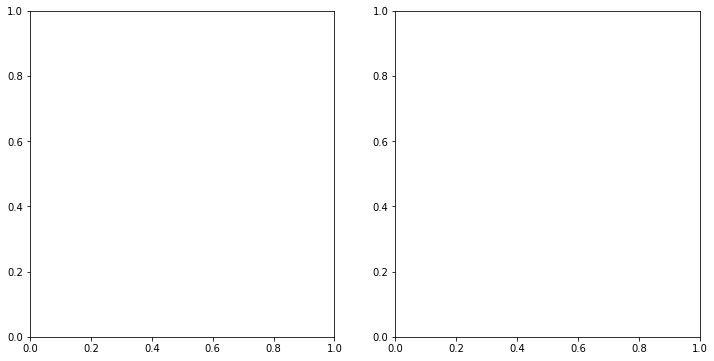

In [32]:
from matplotlib.pylab import subplots
#Put networks in evaluation mode.
big_encoder.eval()
big_decoder.eval()

with torch.no_grad():
    image_rows = 8
    fig, (ax1, ax2) = subplots(1, 2, figsize=(12, 6))
    u = torch.randn((image_rows**2, z_size), device=device)
    
    #Construct images from 1 layer VAE
    image_1 = big_decoder(u)
    image_1 = image_1.reshape((-1, *image_shape))
    
    #Construct image from 2 layer VAE
    z = small_decoder(u)
    image_2 = big_decoder(z)
    image_2 = image_2.reshape((-1, *image_shape))

#Display images
show_image(ax1, image_1, image_rows)
show_image(ax2, image_2, image_rows)

In [27]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pylab as plt

#Image slider 1
is1 = widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(image_set),
    description='Image 1'
)

#Color picker 1
cp1 = widgets.ColorPicker(
    description='Color 1',
    value='#00FF00',
    disabled=False
)

#Image slider 2
is2 = widgets.BoundedIntText(
    value=1,
    min=0,
    max=len(image_set),
    description='Image 2'
)

#Color picker 2
cp2 = widgets.ColorPicker(
    description='Color 2',
    value='#FF0000',
    disabled=False
)

width = 4
steps = width**2

def hex_to_tensor(hex_color):
    rgb = [int(hex_color[1+i:3+i], 16)/255. for i in range(3)]
    return torch.tensor(rgb)

def update_image(idx_1, idx_2, color_1, color_2):
    fig, ax = plt.subplots(1, 4, figsize=(12, 3))
    with torch.no_grad():
        #Get images
        image_1 = image_set.color(idx_1, color_1)
        image_2 = image_set.color(idx_2, color_2)
        
        show_image(ax[0], image_1)
        show_image(ax[3], image_2)
        
        image_1, image_2 = image_1.to(device), image_2.to(device)
        a = torch.linspace(0, 1, steps, device=device).unsqueeze(1)

        #Find means from big encoder and interpolate
        z0 = big_encoder(image_1.unsqueeze(0))[0]
        z1 = big_encoder(image_2.unsqueeze(0))[0]
        zs = z0*(1-a)+a*z1

        #stage 1 reconstructions
        image_1 = big_decoder(zs)
        image_1 = image_1.reshape((-1, *image_shape))
        show_image(ax[1], image_1, width)

        #Find further means from stage 2 and interpolate
        u0 = small_encoder(z0)[0]
        u1 = small_encoder(z1)[0]
        us = u0*(1-a)+a*u1

        #Stage 2 reconstructions
        zs_2 = small_decoder(us)
        image_2 = big_decoder(zs_2)
        image_2 = image_2.reshape((-1, *image_shape))
        show_image(ax[2], image_2, width)
        return fig
        
interactive_plot = widgets.interactive(update_image, idx_1=is1, idx_2=is2, color_1=cp1, color_2=cp2)
output = interactive_plot.children[-1]

display(interactive_plot)

interactive(children=(BoundedIntText(value=0, description='Image 1', max=60000), BoundedIntText(value=1, descr…

In [22]:
image_1_color = widgets.ColorPicker(
    concise=False,
    description='Pick a color for image 1',
    value='#FFFFFF',
    disabled=False
)
display(image_1_color)

ColorPicker(value='#FFFFFF', description='Pick a color for image 1')

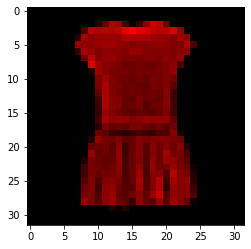

In [25]:
color = image_1_color.value
example = image_set.color(3, color)
plt.imshow(to_pil_image(example))